# Alternative Analysis Using the Swing Weight Matrix

An IPython Notebook implementation of the Systems Engineering trade study method described at http://sebokwiki.org/wiki/Decision_Management.

## Table of Contents

0. [Import Modules](#Import)
1. [Declare Variables and Define Functions](#VarFunc)
2. [Input Files](#Input)
3. [Score Alternatives](#AltScoring)
4. [Calculate Swing Weights](#CalcSW)
5. [Evaluate Alternative Value](#AltValue)
6. [Visualize Output](#Viz)
7. [Create HTML Report](#Report)

In [1]:
%matplotlib inline

## Import Modules <a name="Import"></a>

In [2]:
from __future__ import division

import numpy as np
import scipy as sp
from scipy.special import expit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid') # plot aesthetics
# plt.style.use('bmh') # plot aesthetics

import markdown
from jinja2 import Environment, FileSystemLoader

--------

## Variable and Function Declarations <a name="VarFunc"></a>

In [3]:
# distribution short names
sigString = 'sigmoid'
linString = 'linear'
powString = 'power'
triString = 'triangular'

# Value function range [0, vfRange]
vfRange = 100.0

# Weights for Importance and Swing for Swing Weight calculation
impWt = 0.65
swWt = 1.0 - impWt

# For large figures with subplots
numPlotCols = 3 # number of columns

# HTML output
htmlReport = True

In [4]:
def scale(x, xMin, xMax):
    """ Returns x between [0.0, 1.0] from original domain of [xMin, xMax]. """
    return (x - xMin) / (xMax - xMin)


In [5]:
def triangular(x, l, c, r):
    """ Returns the [0,100] scaled triangular value function evaluated 
    at x for (l)eft, (c)enter, (r)ight triangular parameters."""
    return vfRange * max(min(((x - l)/(c - l)), ((r - x)/(r - c))), 0.0)


In [6]:
def bell(x, a, b, c):
    """ Returns the [0,100] scaled generalized bell curve 
    evaluated at x for (c)enter and shape parameters a and b."""
    return vfRange * 1.0 / (1.0 + pow(np.abs((x - c)/a), (2.0*b)))

In [7]:
def sigmoid(x, a, c):
    """Returns the [0,100] scaled sigmoid function evaluated 
    at x for (a)lpha and (c)enter."""
    return vfRange * (1.0 / (1.0 + np.exp(-1.0 * a * (x - c))))

--------

## Read Input Files <a name="Input"></a>

### Objectives and Measures
Read directly into a `pandas` DataFrame

Define the set of value function families to use:

Family  |  Value Function
------  | ----------------------------------------
Linear  |  $$ f(x) = mx + b $$
Power   |  $$ f(x) = mx^a $$
Sigmoid |  $$ f(x) = 100\frac{a}{b + e^{-ax/2}} $$


In [8]:
objDF = pd.read_csv('./input/objectives.csv', index_col = ['Objective', 'Measure'])
# objDF   # Uncomment to view the DataFrame inline

#### Build the Value Functions for Each Objective and Measure
This section creates plots of the value functions defined for each measure.  The result is a series of figure with subplots of each value function.

----------
**Note:** *If you defined additional value functions above, you will need to add these to the below loop to make sure they are evaluated.*

---------

In [9]:
tmpDF = pd.DataFrame(columns=['Measure', 'Score', 'Value'])

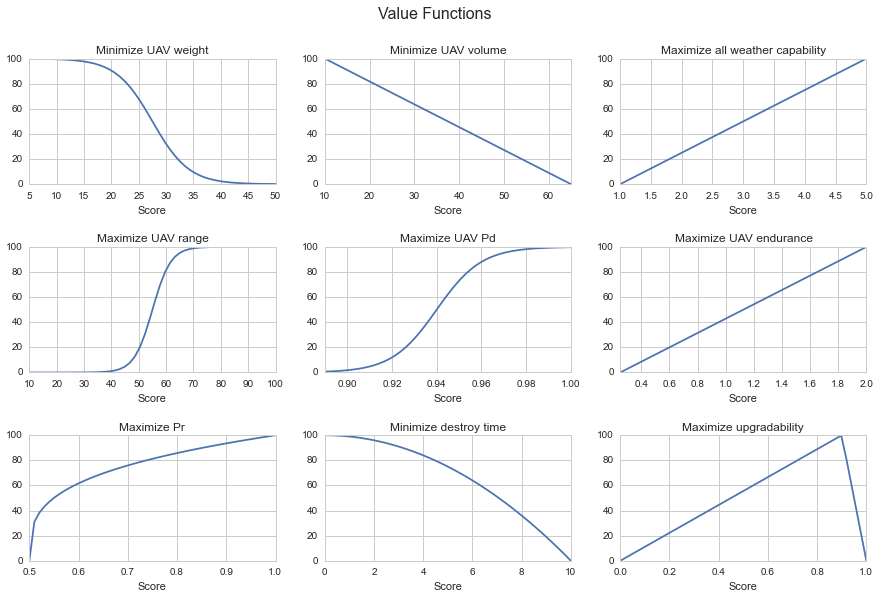

In [10]:
# Get the number of unique Measures to plot
numPlotRows = int(round(np.ceil(len(objDF.index.levels[1].unique()) / numPlotCols), 0))
fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize = (15, 9))

# Loop through the subplots and objDF indices
for ax, idx in zip(axs.flat, objDF.index):
    vals = objDF.loc[idx] # get the dataframe columns for this index 
    axMin = float(vals.Minimum)
    axMax = float(vals.Maximum)
    domain = np.linspace(axMin, axMax)
    
    # Build the corresponding value function
    if vals.Family == 'sigmoid':
        valFunc = [sigmoid(i, float(vals.Param1), vals.Param2) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [vfRange - i for i in valFunc]
    elif vals.Family == 'linear':
        valFunc = [vfRange * scale(i, axMin, axMax) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [vfRange - i for i in valFunc]
    elif vals.Family == 'power':
        valFunc = [vfRange * np.power(scale(i, axMin, axMax), vals.Param1) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [max(valFunc) - i for i in valFunc]
    elif vals.Family == 'triangular':
        valFunc = [triangular(i, axMin, vals.Param1, axMax) for i in domain]
        if float(vals.Slope) == -1.0:
            valFunc[:] = [max(valFunc) - i for i in valFunc]
    else:
        valsFunc = [0]*len(domain)
        print 'This value function family is not yet implemented.'
    
    tmpDF.Measure = str(idx[1]) # Assign the Measure
    tmpDF.Score = domain
    tmpDF.Value = valFunc
    
    plotTitle = str(idx[1])
#     plt.xlabel('x, (' + str(vals.Units) + ')')
#     plt.ylabel("V(x)")
    tmpDF.plot(ax=ax, x = 'Score', y = 'Value', title = plotTitle, legend = False)
    
    plt.subplots_adjust(hspace = 0.5)


plt.suptitle('Value Functions', fontsize = 16)
plt.savefig('./figures/value-functions.png', bbox_inches='tight')
plt.show()

### Alternatives
Read directly into a `pandas` DataFrame

In [11]:
altDF = pd.read_csv('./input/alternatives.csv', index_col=['Objective', 'Measure', 'Alternative'])
altDF['Consequence'] = np.NaN
# altDF   #  Uncomment to view inline

--------

## Score each Alternative against each Objective and Measure <a name="AltScoring"></a>

In [12]:
for item, val in altDF.iterrows():
    idxString = list(item) # convert this alternative's index to a list
    print '\n\nidxString is: ', idxString
    print 'val is: \n -----\n', val, '\n-----'
    objIdx = idxString[0:2] # drop the 'Alternative' from the index used for the objective DataFrame
    print 'objective index is: \n', objIdx
    obj = objDF.ix[objIdx[0],objIdx[1],] # get the corresponding objective for this index
    print 'objDF row is: \n', obj
    
    score = np.NaN
    funcFamily = str(obj['Family']) # get the corresponding value function family
    paramX = altDF.ix[idxString[0], idxString[1], idxString[2]]['Score'] # the measured value for this alternative
    paramSlope = objDF.ix[objIdx[0],objIdx[1]]['Slope'] # the slope
    paramXMin = objDF.ix[objIdx[0],objIdx[1]]['Minimum'] # minimum acceptable
    paramXMax = objDF.ix[objIdx[0],objIdx[1]]['Maximum'] # maximum desirable
    paramX1 = objDF.ix[objIdx[0],objIdx[1]]['Param1'] # 1st function parameter
    paramX2 = objDF.ix[objIdx[0],objIdx[1]]['Param2'] # 2nd function parameter
    paramX3 = objDF.ix[objIdx[0],objIdx[1]]['Param3'] # 3rd function parameter

    if funcFamily == sigString:
        print str(idxString[0:2]) + ' is ' + sigString
        score = sigmoid(paramX, paramX1, paramX2)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == linString:
        print str(idxString[0:2]) + ' is ' + linString
        score = 100.0 * scale(paramX, paramXMin, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == powString:
        print str(idxString[0:2]) + ' is ' + powString
        score = np.power(scale(paramX, paramXMin, paramXMax), paramX1) #pow_func(paramX, 2.0, paramXMin, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    elif funcFamily == triString:
        print str(idxString[0:2]) + ' is ' + triString
        score = triangular(paramX, paramXMin, paramX1, paramXMax)
        if float(paramSlope) == -1.0:
            score = vfRange - score
    else:
        print 'The "',funcFamily, '" value function family is not yet implemented.'

    print 'Value against this measure is ', score
    altDF.loc[(idxString[0], idxString[1], idxString[2]),'Consequence'] = np.round(float(score), 3)
                  




idxString is:  ['Relocate UAV', 'Minimize UAV weight', 'Cardinal']
val is: 
 -----
Score            5
Units          lbs
Consequence    NaN
Name: (Relocate UAV, Minimize UAV weight, Cardinal), dtype: object 
-----
objective index is: 
['Relocate UAV', 'Minimize UAV weight']
objDF row is: 
Importance         35
Minimum             5
Maximum            50
Ideal               5
Units             lbs
Family        sigmoid
Slope              -1
Param1            0.3
Param2           27.5
Param3            NaN
Name: (Relocate UAV, Minimize UAV weight), dtype: object
['Relocate UAV', 'Minimize UAV weight'] is sigmoid
Value against this measure is  99.8830489735


idxString is:  ['Relocate UAV', 'Minimize UAV volume', 'Cardinal']
val is: 
 -----
Score           12
Units          ft3
Consequence    NaN
Name: (Relocate UAV, Minimize UAV volume, Cardinal), dtype: object 
-----
objective index is: 
['Relocate UAV', 'Minimize UAV volume']
objDF row is: 
Importance        45
Minimum           10
M

/Users/george/anaconda/lib/python2.7/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


In [13]:
# altDF   # Uncomment to view the DataFrame inline

-----------

## Calculate the Swing Weight for each Objective and Measure <a name="CalcSW"></a>

In [14]:
objDF.loc[:,'Swing'] = np.NaN

In [15]:
for idx, val in objDF.iterrows():
    try:
        objMin = min(altDF.loc[(idx[0], idx[1]),'Score'])
        objMax = max(altDF.loc[(idx[0], idx[1]),'Score'])
    except:
        print "\nNo Score found for ", idx
        objMin = np.NaN
        objMax = np.NaN
        
    swing = objMax - objMin
    objDF.loc[(idx[0], idx[1]),'Swing'] = swing
    print idx, ' min: ', objMin, '  max: ', objMax, '  swing: ', swing

('Relocate UAV', 'Minimize UAV weight')  min:  5.0   max:  40.0   swing:  35.0
('Relocate UAV', 'Minimize UAV volume')  min:  12.0   max:  50.0   swing:  38.0
('Employ UAV', 'Maximize all weather capability')  min:  1.0   max:  5.0   swing:  4.0
('Employ UAV', 'Maximize UAV range')  min:  10.0   max:  100.0   swing:  90.0
('Employ UAV', 'Maximize UAV Pd')  min:  0.9   max:  0.94   swing:  0.04
('Employ UAV', 'Maximize UAV endurance')  min:  0.5   max:  2.0   swing:  1.5

No Score found for  ('Recover UAV', 'Maximize Pr')
('Recover UAV', 'Maximize Pr')  min:  nan   max:  nan   swing:  nan

No Score found for  ('Recover UAV', 'Minimize destroy time')
('Recover UAV', 'Minimize destroy time')  min:  nan   max:  nan   swing:  nan

No Score found for  ('Growth Potential', 'Maximize upgradability')
('Growth Potential', 'Maximize upgradability')  min:  nan   max:  nan   swing:  nan


### Calculate the Unnormalized Weight

In [16]:
objDF.loc[:,'Weight'] = impWt * objDF.Importance + swWt * objDF.Swing

### Calculate the Normalized Weight

In [17]:
objDF.loc[:,'NormdWt'] = objDF.loc[:,'Weight'] / objDF.loc[:,'Weight'].sum()

In [18]:
# objDF   # Uncomment to view the DataFrame inline

Checksum for the normalized Swing Weight

In [19]:
if not round(objDF.NormdWt.sum(),3) == 1.0:
    print "Something went wrong.  Sum of normalized weights is ", objDF.NormdWt.sum(), ", not 1.0."
else:
    print "Checksum succeeded."

Checksum succeeded.


-------------

## Evaluating the Alternative's Value <a name="AltValue"></a>

### Calculate Total Value for Each Alternative

$$
V(x) = \sum_{i = 1}^{n}w_{i} v_{i}(x_{i})
$$
where $V(x)$ is the total value, $i$ is the index of the objective/measure, $w_i$ is the normalized weight for objective/measure $i$, $x_i$ is the alternative's score for objective measure $i$, and $v_i(x_i)$ is the corresponding value of $x_i$.

In [20]:
for idx, vals in altDF.iterrows():
    altDF.loc[:,'WtdConsequence'] = objDF.loc[(idx[0],idx[1]),'NormdWt'] * altDF.Consequence


In [21]:
# altDF    # Uncomment to view the DataFrame inline

------------

## Visualizing Output <a name="Viz"></a>

#### Heatmap (Consequences Scorecard)

Display the relative performance of each Alternative against each Measure.

In [22]:
heatDF = altDF.drop(['Score', 'Units', 'WtdConsequence'], axis = 1)
heatDF.reset_index(inplace=True)

In [23]:
summaryDF = altDF.drop(['Score', 'Consequence'], axis=1).groupby(level = 'Alternative').agg(sum)
summaryDF.columns = ['Value']
# summaryDF   # Uncomment to view the DataFrame inline

In [24]:
tmpDF = altDF.drop(['Units', 'Consequence'], axis = 1)
# tmpDF   # Uncomment to view the DataFrame inline

In [25]:
for idx, cols in tmpDF.iterrows():
    val = summaryDF.loc[(idx[2]), 'Value']
    tmpDF.loc[idx,'Value'] = val


In [26]:
heat_rect = heatDF.pivot('Alternative', 'Measure', 'Consequence')
# heat_rect   # Uncomment to view the DataFrame inline

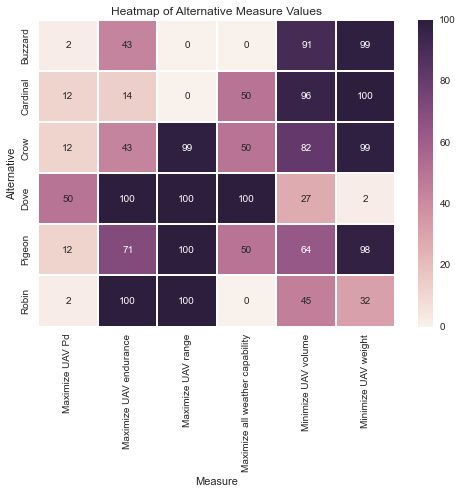

In [27]:
sns.heatmap(np.round(heat_rect, 0), annot=True, fmt='g')
plt.title("Heatmap of Alternative Measure Values")
plt.savefig('./html_report/images/heatmap.png', bbox_inches='tight')

#### Trellis Plot of Alternative Value vs Measure Score

Allows a quick comparison of the total value and original score of Alternatives against all Measures.

In [28]:
summaryDF.reset_index(inplace=True)

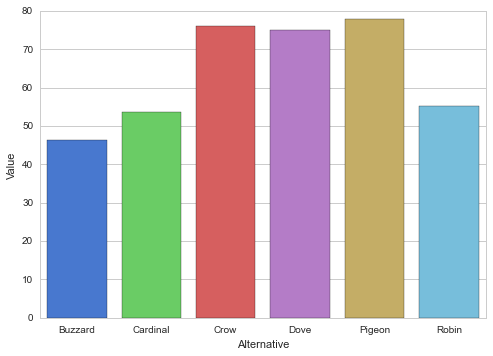

In [29]:
sns.barplot('Alternative', 'Value', data=summaryDF, palette="muted")
plt.savefig('./html_report/images/value-barplot.png', bbox_inches='tight')

In [30]:
tmpDF.reset_index(inplace=True)

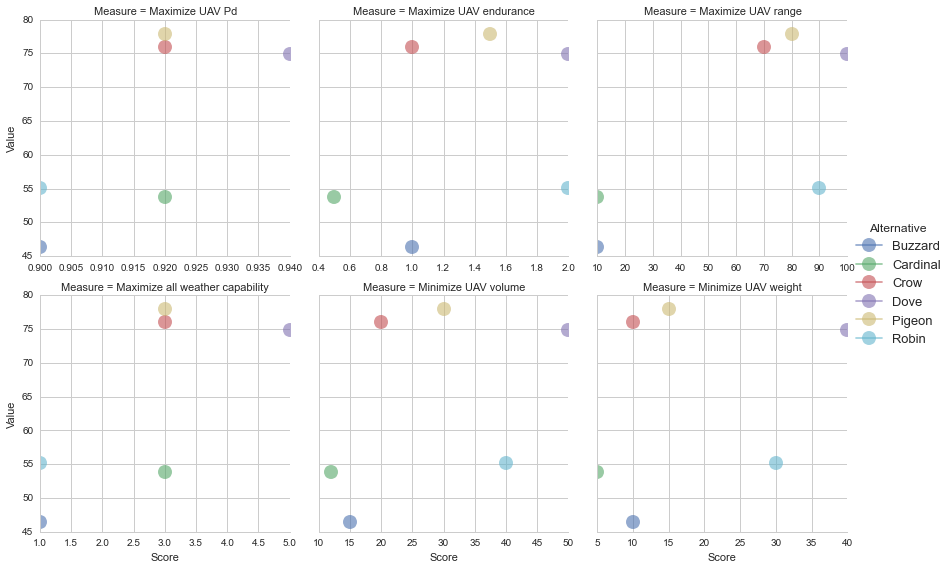

In [31]:
grid = sns.FacetGrid(tmpDF, col="Measure", hue="Alternative", col_wrap=3, size=4, legend_out = True, sharex=False)
grid.map(plt.plot, "Score", "Value", marker="o", ms=14, alpha=0.6)
grid.fig.tight_layout(w_pad=1)
sns.set_context("talk")
grid.add_legend()
grid.savefig('./html_report/images/measure-trellis.png', bbox_inches='tight')

-----------------

## Create HTML Report <a name="Report"></a>

You can manipulate the string variable below for your needs.  These are used in the default template.

In [32]:
if htmlReport:
    # Adjust these strings to your needs:
    pageTitle = "alt-swing"
    reportTitle = "Default alt-swing Report"
    author = "Author Name"
    frontMatter = "This is the default alt-swing report.  You can customize it for your needs."
    content = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."
    trellis_text = "Nunc vel gravida dui, ac aliquam augue. Vivamus eu ultrices mauris, sit amet dictum diam."
    barplot_text = "Vivamus eu ultrices dui, ac aliquam augue."
    
    # Convert tables
    summaryDF = altDF.drop(['Score', 'Consequence'], axis=1).groupby(level = 'Alternative').agg(sum)
    summaryDF.columns = ['Value']
    
    altTable = pd.read_csv('./input/alternatives.csv', index_col=['Objective', 'Measure', 'Alternative', 'Units'])
    altTable = altTable.unstack(['Objective', 'Measure', 'Units'])
    
    blufHTML = summaryDF.to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%"">')
    
    altHTML = altTable.to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%">')
    
    objHTML = objDF.drop(['Family', 'Slope', 'Param1', 'Param2', 'Param3', 'Weight'], axis=1).to_html()\
                .replace('<table border="1" class="dataframe">','<table border="0" style="font-size:80%">')
    
    # Read and convert markdown sections
    with open('./templates/content/intro-section.md', 'r') as f:
        introText = markdown.markdown(f.read())
    
    with open('./templates/content/bluf-section.md', 'r') as f:
        blufText = markdown.markdown(f.read())
        
    with open('./templates/content/obj_meas-section.md', 'r') as f:
        obj_measText = markdown.markdown(f.read())

    with open('./templates/content/alternative-section.md', 'r') as f:
        altText = markdown.markdown(f.read())
    
    env = Environment(loader=FileSystemLoader('./templates/'))
    template = env.get_template('template.html')
    
    # 
    output_from_parsed_template = template.render(
        title = reportTitle, page_title = pageTitle, author = author,
        bluf_content = blufText, bluf_table = blufHTML, 
        intro_content = introText, 
        obj_content = obj_measText, obj_meas_table = objHTML,
        alt_content = altText, alt_table = altHTML, 
        trellis_text = trellis_text, barplot_text = barplot_text
        )

    output_from_parsed_template = output_from_parsed_template.encode("utf-8")
    
    # Write the HTML report
    with open("./html_report/alt-swing_report.html", "w") as fh:
        fh.write(output_from_parsed_template)
    


You can now open the HTML document at `./html_report/alt-swing_report.html`.  The default template uses the [Skeleton](http://www.getskeleton.com) CSS framework.

-----------